In [17]:
!hostnamectl

   Static hostname: lorien.atp-fivt.org
         Icon name: computer-server
           Chassis: server
        Machine ID: a3e5546e90014b9b9a9e42d56d79be4a
           Boot ID: fbcdb94f5063457d819c01dbc3808bff
  Operating System: Ubuntu 18.04.5 LTS
            Kernel: Linux 4.15.0-208-generic
      Architecture: x86-64


In [18]:
# !pip install deskew

In [19]:
import cv2
import math
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from deskew import determine_skew

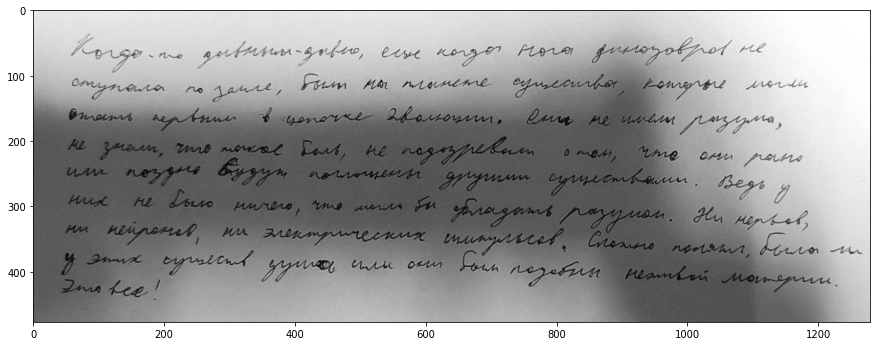

In [30]:
img = cv2.imread('/home/MSMalcev/Thesis/page4.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 30))
plt.imshow(img, cmap='gray')

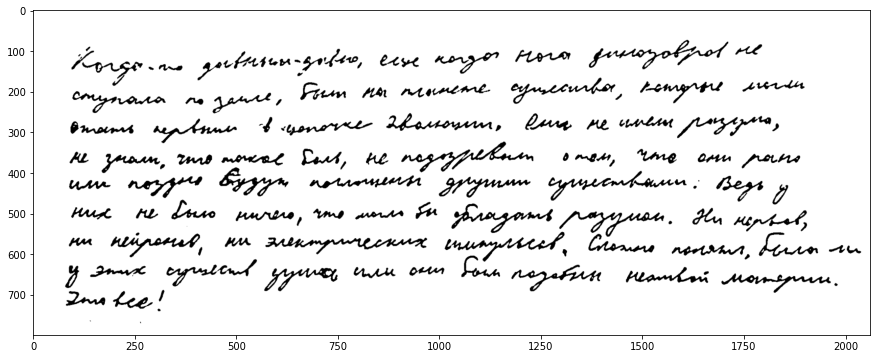

In [35]:
image_height = 10000
image_width = 2048

def rotate(image, angle, background):
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

def bradley_thresholding(image):
    kernel_size = 32
    percent_lower = 6
    sigma = 7 # or ((kernel_size ** 2 - 1) / 12) ** 0.5 https://stackoverflow.com/questions/35340197/box-filter-size-in-relation-to-gaussian-filter-sigma
    
    average_around_pixel = tfa.image.gaussian_filter2d(image, filter_shape=kernel_size, sigma=sigma)

    
    res = tf.where(tf.cast(image, tf.float32) < average_around_pixel * (100 - percent_lower) / 100, tf.constant(0, dtype=tf.uint8), tf.constant(255, dtype=tf.uint8))
    return res

def preprocess_image(image):
    image = tf.image.resize(image, size=(image_height, image_width), preserve_aspect_ratio=True)  # to make bluring consistent
    image = tfa.image.gaussian_filter2d(image, filter_shape=6, sigma=1.5)

    image = bradley_thresholding(image).numpy()[:, :, 0]
    
    angle = determine_skew(image)
    image = rotate(image, angle, 255)
    
    # image = resize_image(image, (image_width, image_height))
    # image = tf.image.resize_with_pad(image, image_height, image_width)  # actually just pads
    # image = tf.cast(image, tf.float32) / 255.0
    return image

preprocessed_img = preprocess_image(img[:, :, np.newaxis])

plt.figure(figsize=(15, 30))
plt.imshow(preprocessed_img, cmap='gray')

## First approach - lines projections

(799, 2061)


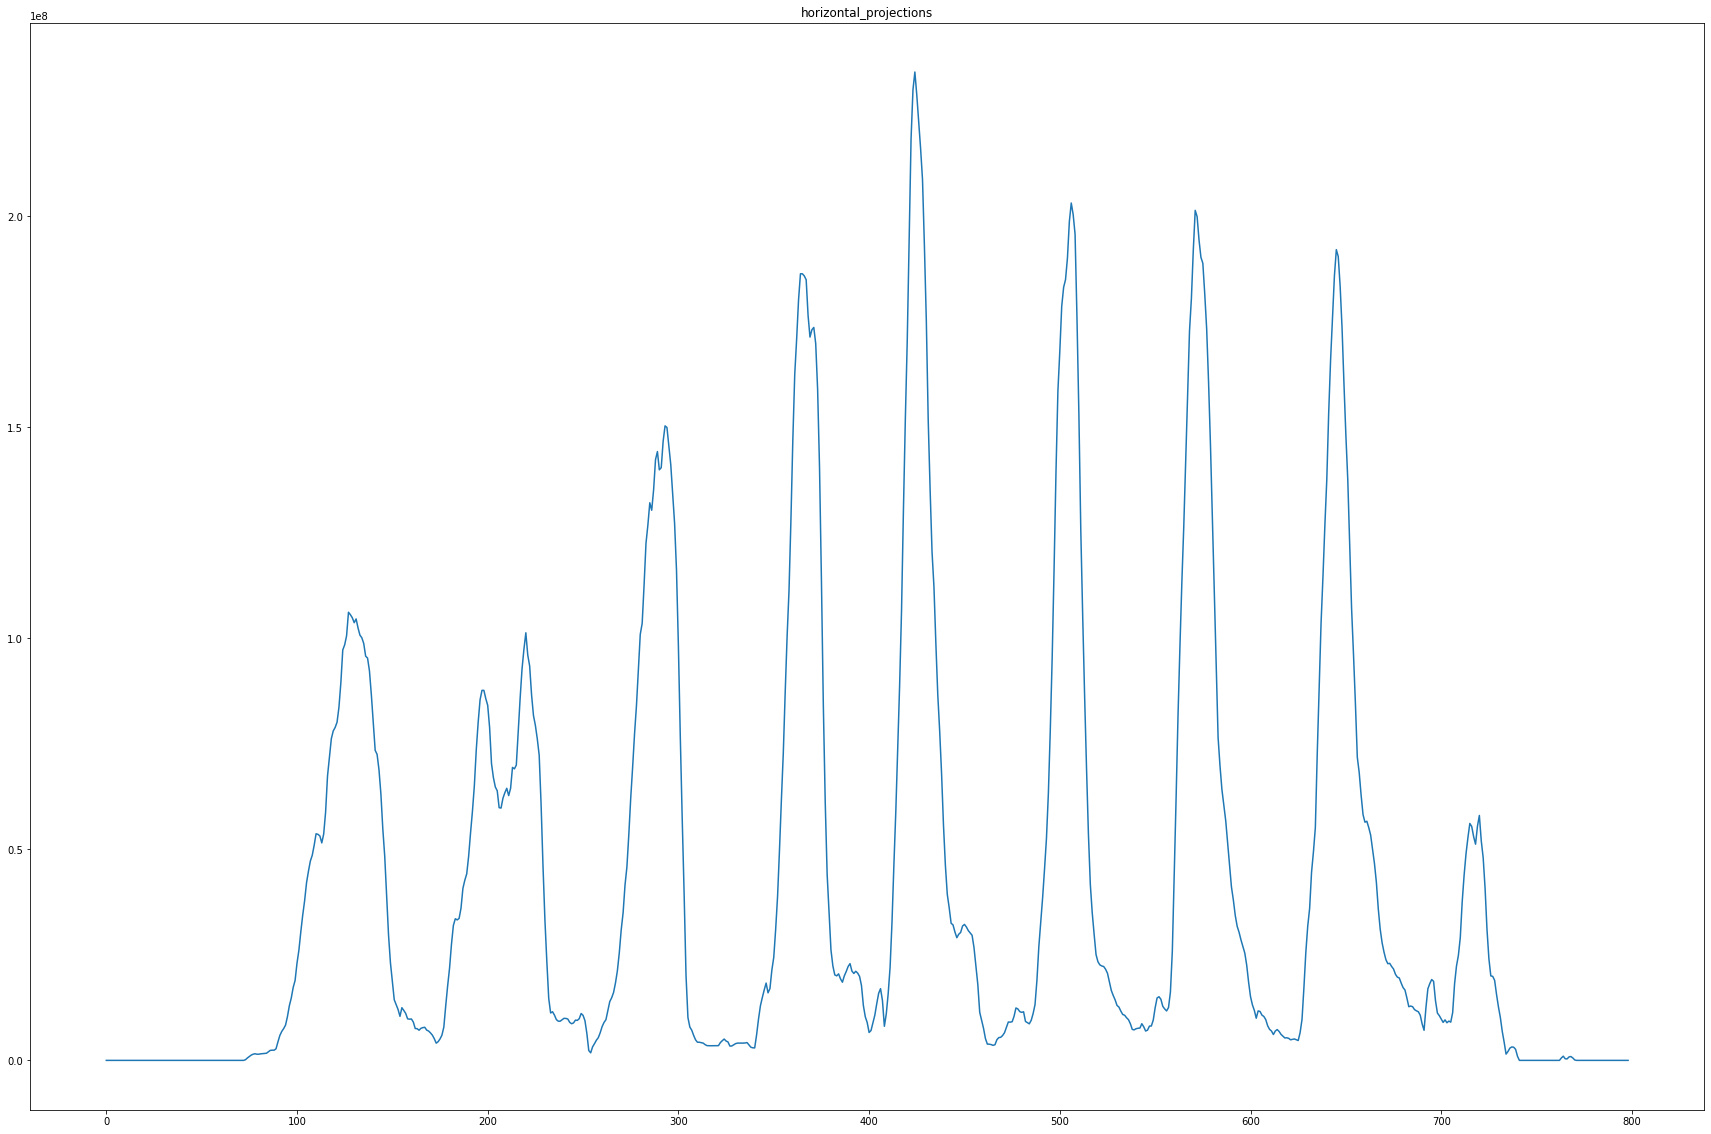

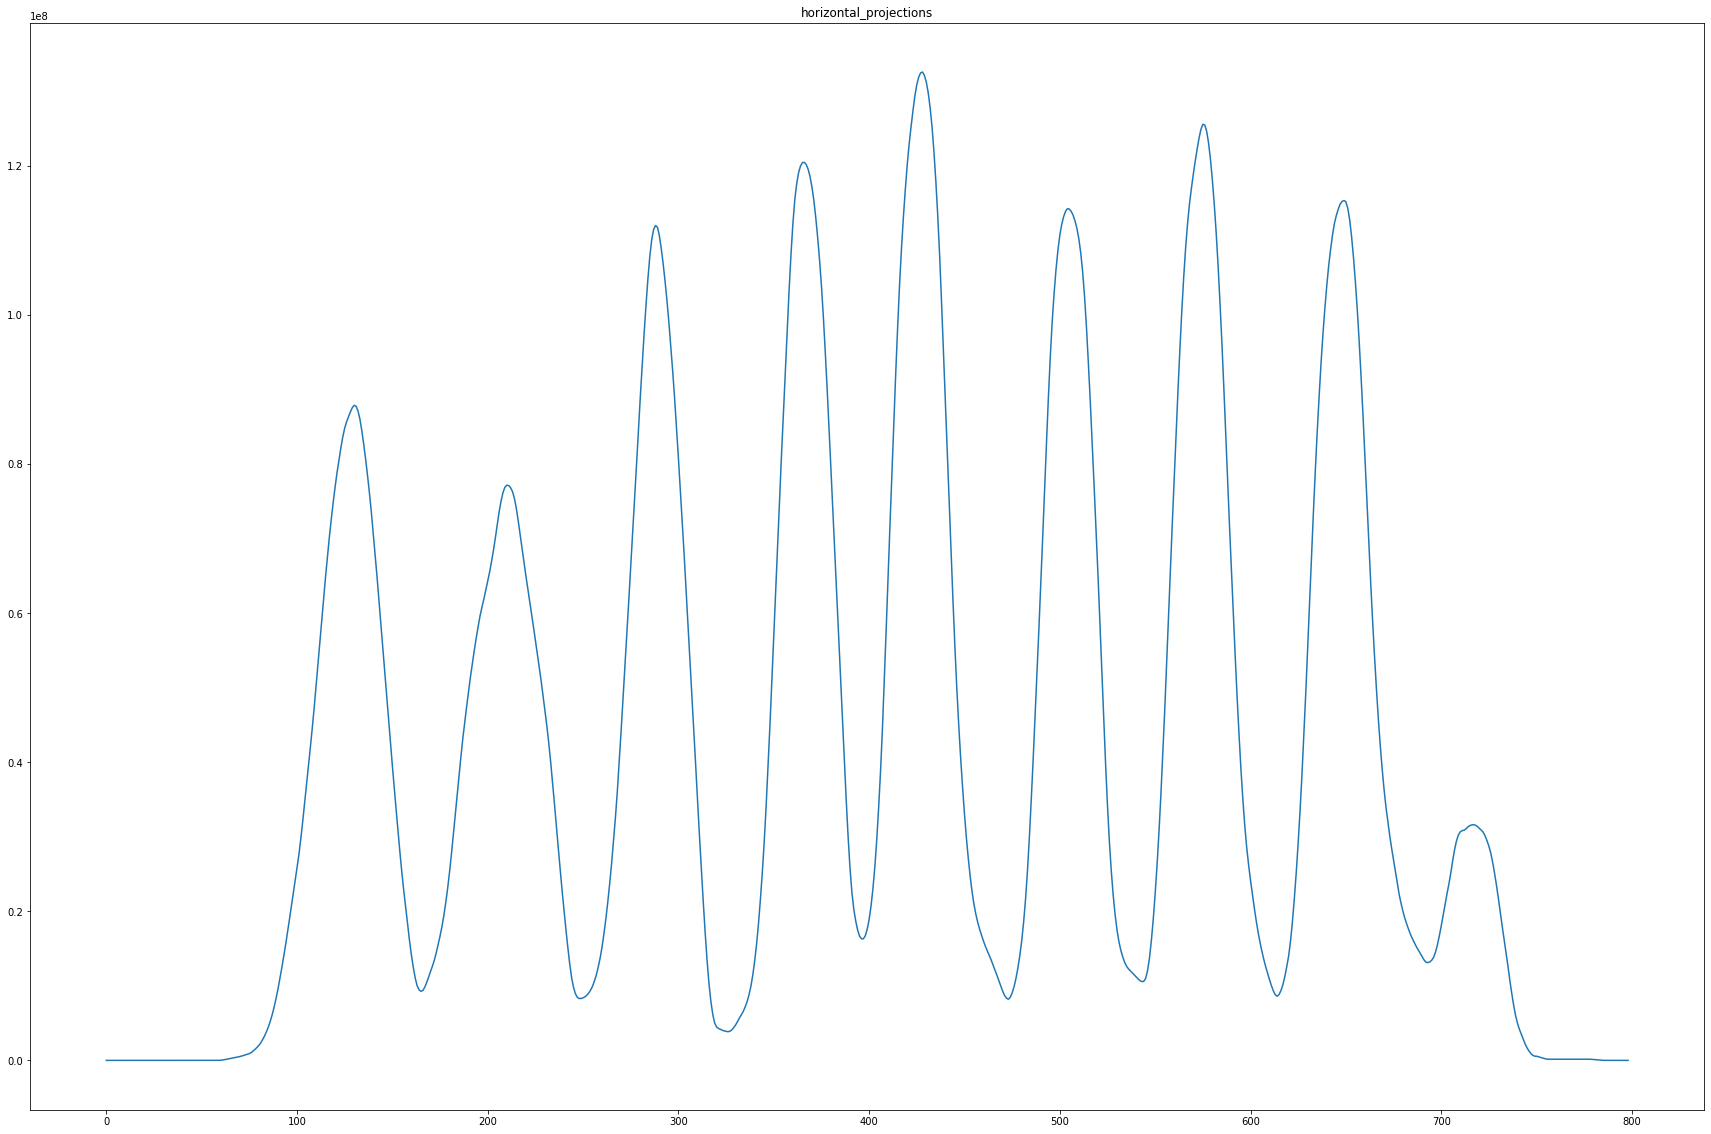

In [36]:
def horizontal_projections(image):
    image = 255 - image
    print((image * np.flip(np.arange(0, image.shape[1], 1))).shape)
    return np.sum(image * np.flip(np.arange(0, image.shape[1], 1)), axis=1)

hpp = horizontal_projections(preprocessed_img)

kernel_size = 30
kernel = np.ones(kernel_size) / kernel_size
hpp_smoothed = np.convolve(hpp, kernel, mode='same')

plt.figure(figsize=(30,20))
plt.title("horizontal_projections")
plt.plot(hpp)

plt.figure(figsize=(30,20))
plt.title("horizontal_projections")
plt.plot(hpp_smoothed)

plt.show()

There will be a problem on short lines as they will be thrown away so we are using the second approach

## Second approach - contours and gluing lines

### Character Segmentation

In [46]:
def show_contours(contours, image):
    res_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(res_img, (x, y), (x + w, y + h), (40, 100, 250), 2)

    plt.figure(figsize=(15, 30))
    plt.imshow(res_img)

def find_contours(image):
    contours, _ = cv2.findContours(255 - image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def filter_contours(contours, image_to_display = None):
    area_threshold_percent = 30
    overlapping_threshold_percent = 50
    
    if not (image_to_display is None):
        temp_img = cv2.cvtColor(image_to_display, cv2.COLOR_GRAY2RGB)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(temp_img, (x, y), (x + w, y + h), (40, 100, 250), 2)
    
    # area thresholding:
    mean_area = np.mean([cv2.contourArea(contour) for contour in contours])
    area_filtered = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > mean_area * area_threshold_percent / 100:
            area_filtered.append(contour)
        elif not (image_to_display is None):
            cv2.rectangle(temp_img, (x, y), (x + w, y + h), (250, 100, 100), 4)
    
    # overlap thresholding:
    area_filtered = sorted(area_filtered, key = lambda ctr: -(cv2.boundingRect(ctr)[2] * cv2.boundingRect(ctr)[3]))
    overlap_filtered = [area_filtered[0]]
    for i in range(1, len(area_filtered)):
        inner_contour = area_filtered[i]
        overlaped = False
        for j in range(i):
            outer_contour = area_filtered[j]
            x_inner, y_inner, w_inner, h_inner = cv2.boundingRect(inner_contour)
            x_outer, y_outer, w_outer, h_outer = cv2.boundingRect(outer_contour)
            
            x_inter = max(x_inner, x_outer)
            w_inter = min(x_inner + w_inner, x_outer + w_outer) - x_inter
            y_inter = max(y_inner, y_outer)
            h_inter = min(y_inner + h_inner, y_outer + h_outer) - y_inter
            
            if w_inter > 0 and h_inter > 0 and w_inter * h_inter / (w_inner * h_inner) > overlapping_threshold_percent / 100:
                overlaped = True
                break
        
        if not overlaped:
            overlap_filtered.append(inner_contour)
        elif not (image_to_display is None):
                cv2.rectangle(temp_img, (x_inner, y_inner), (x_inner + w_inner, y_inner + h_inner), (250, 0, 0), 4)

    if not (image_to_display is None):
        plt.figure(figsize=(15, 30))
        plt.imshow(temp_img)
            
    return tuple(overlap_filtered)

In [47]:
#dilation
kernel = np.ones((3, 3), np.uint8)
dilated = 255 - cv2.dilate(255 - preprocessed_img, kernel, iterations = 1)

# plt.figure(figsize=(15, 30))
# plt.imshow(dilated, cmap='gray')

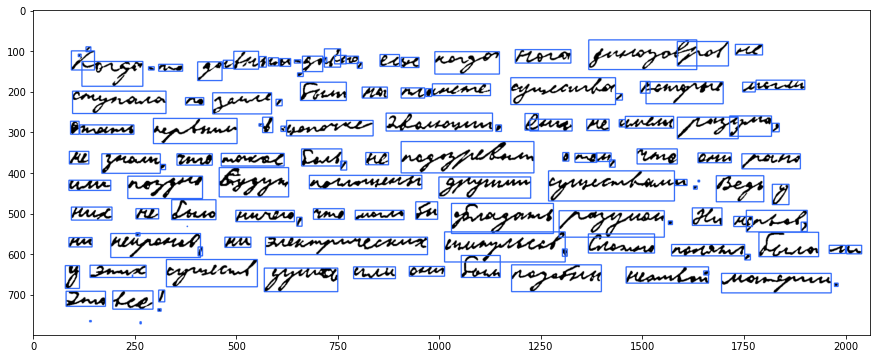

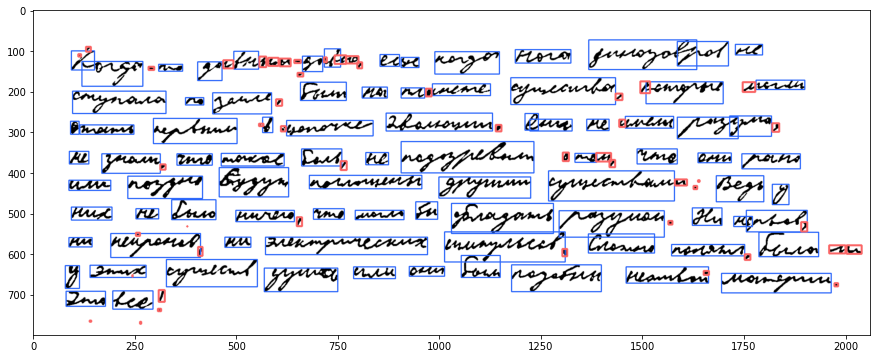

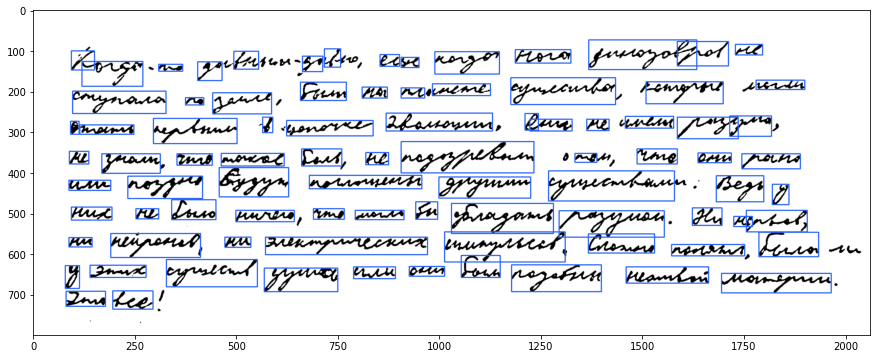

In [48]:
char_contours = find_contours(preprocessed_img)
show_contours(char_contours, preprocessed_img)
char_contours = filter_contours(char_contours, preprocessed_img)
show_contours(char_contours, preprocessed_img)

# contour_areas_hist = []
# for i in range(1000):
#     cur_count = 0
#     for contour in char_contours:
#         # x, y, w, h = cv2.boundingRect(contour)
#         # if (w * h == i):
#         #     cur_count +=1
#         if (int(cv2.contourArea(contour)) == i):
#             cur_count += 1
#     contour_areas_hist.append(cur_count)

# plt.figure(figsize=(20, 10))
# plt.plot(contour_areas_hist)

# areas_sum = 0
# for contour in char_contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     areas_sum += w * h
#     # areas_sum += cv2.contourArea(contour)
    
# mean = areas_sum / len(char_contours)
# print(mean)

# plt.show()

### Words Segmentation

In [49]:
def add_lines(image, contours, line_len):
    # fraction = 0.1
    width = 5
    
    res_img = image.copy()
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        y_mid = y + h // 2
        cv2.line(res_img, (x - line_len, y_mid), (x + w + line_len, y_mid), 0, width)
        # cv2.line(res_img, (x - line_len, int(y_mid + h * fraction)), (x + w + line_len, int(y_mid + h * fraction)), 0, 2)
        # cv2.line(res_img, (x - line_len, int(y_mid - h * fraction)), (x + w + line_len, int(y_mid - h * fraction)), 0, 2)
    
    return res_img

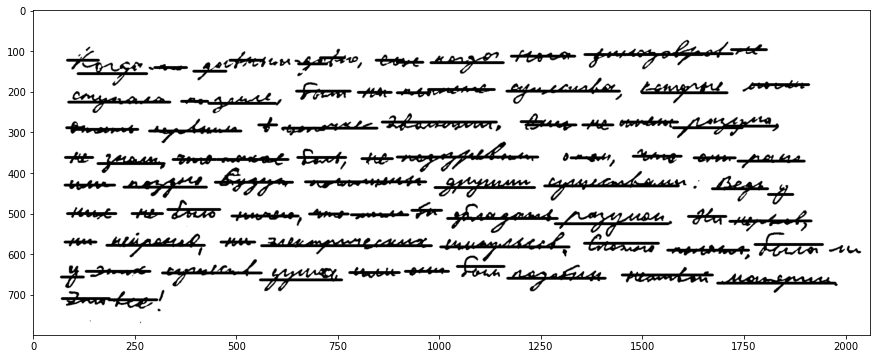

In [50]:
img_char_lines = add_lines(preprocessed_img, char_contours, 10)

plt.figure(figsize=(15, 30))
plt.imshow(img_char_lines, cmap='gray')

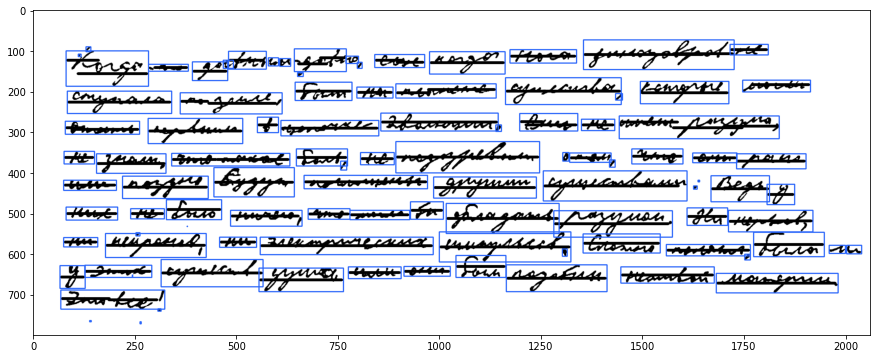

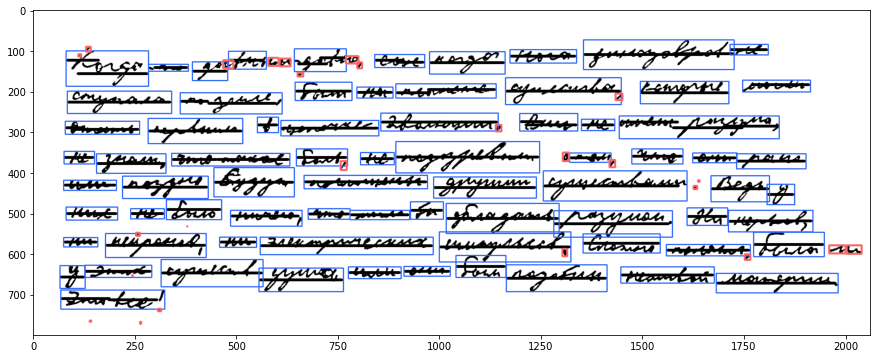

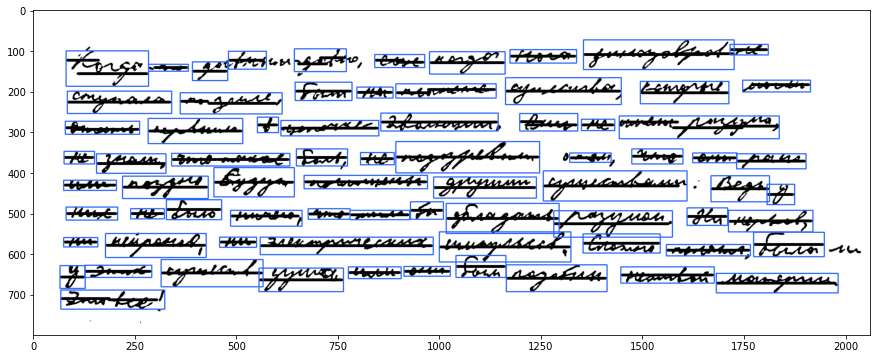

In [51]:
word_contours = find_contours(img_char_lines)
show_contours(word_contours, img_char_lines)
word_contours = filter_contours(word_contours, img_char_lines)
show_contours(word_contours, img_char_lines)

## Lines Segmentation

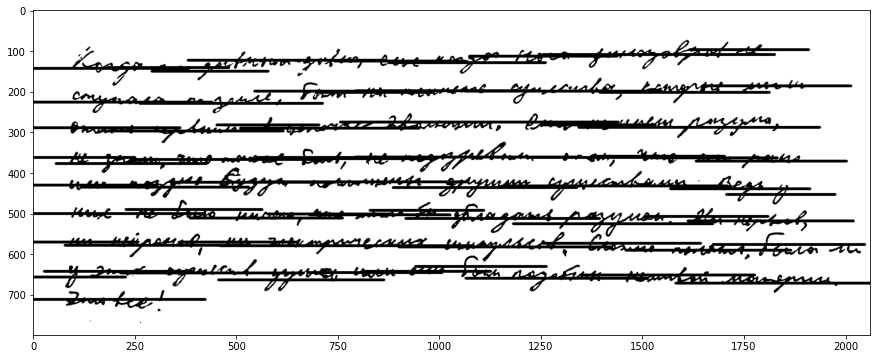

In [52]:
img_word_lines = add_lines(preprocessed_img, word_contours, 100)

plt.figure(figsize=(15, 30))
plt.imshow(img_word_lines, cmap='gray')

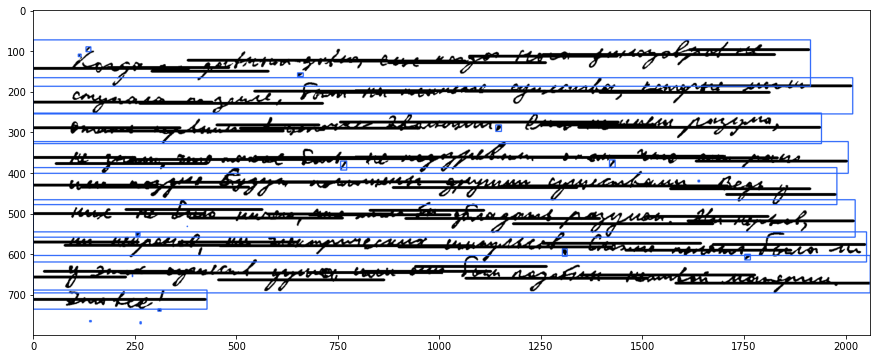

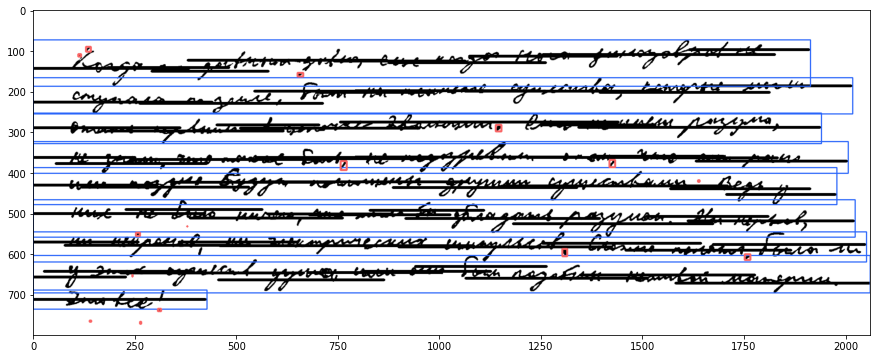

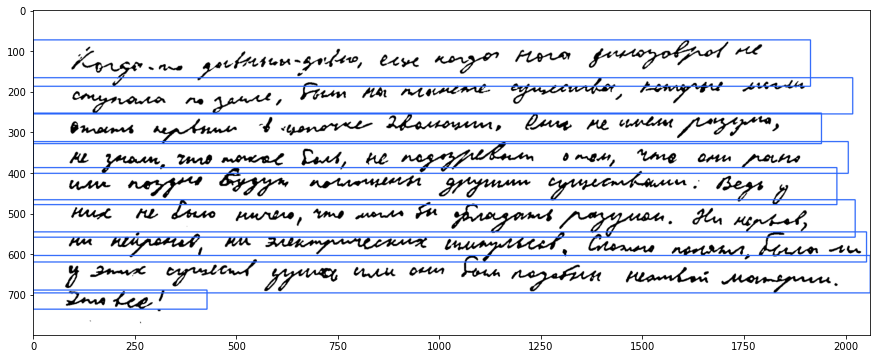

In [53]:
line_contours = find_contours(img_word_lines)
show_contours(line_contours, img_word_lines)
line_contours = filter_contours(line_contours, img_word_lines)
show_contours(line_contours, preprocessed_img)
line_contours = sorted(line_contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

## Extracting lines

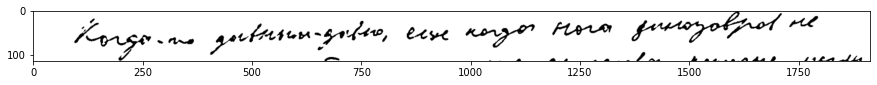

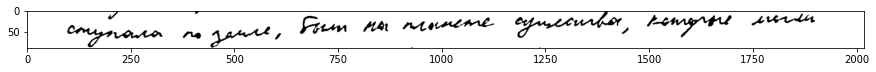

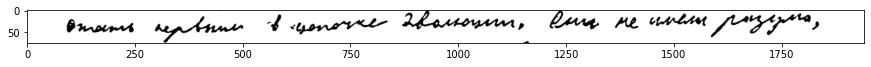

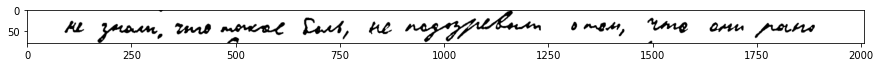

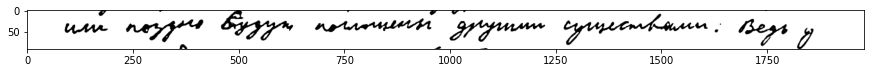

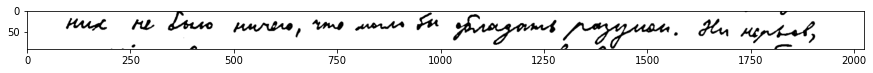

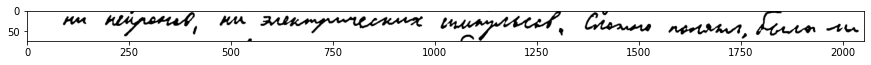

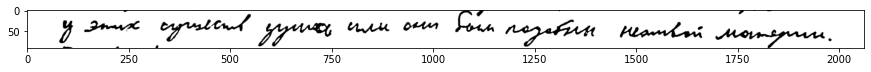

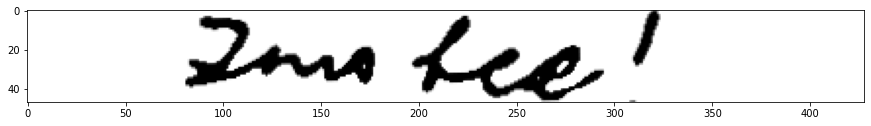

In [54]:
for ctr in line_contours:
    x, y, w, h = cv2.boundingRect(ctr)
    plt.figure(figsize=(15, 10))
    plt.imshow(preprocessed_img[y : y + h, x : x + w], cmap='gray')